In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from tqdm.auto import tqdm
from mplsoccer import Pitch, VerticalPitch
import geopandas as gpd
from shapely.geometry import Point, MultiPoint, Polygon
from shapely.ops import voronoi_diagram
from collections import defaultdict
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import Polygon as PolygonPatch
from PIL import Image
from io import BytesIO
import requests
import math


plt.rcParams['font.family'] = 'Bahnschrift'  # Set global font

# 0) Data Overview and Pre-Processing

## Tracking Data

In [2]:
df = pd.read_pickle('klopped_France_Belgium.pkl')

Adapt the timestamp format:

In [3]:
df['timestamp'] = df['timestamp'].astype('timedelta64[ms]')  # Ensures it's in milliseconds
df['timestamp'] = df['timestamp'].apply(lambda x: str(x)[7:])  # Removes '0 days '

I center the data to the standard UEFA: 105x68 with bottom left corner in (0,0):

In [4]:
def shift_coordinates(df):
    for column in df.columns:
        if column.endswith('_x'):
            df[column] = df[column] + 52.5
        elif column.endswith('_y'):
            df[column] = df[column] + 34
            
    return df 

df_shifted = shift_coordinates(df)

Invert direction of attack to be coherent with the event data:

In [5]:
def switch_direction(df):
	for column in df.columns:
		if column.endswith('_x'):
			df[column] = 105 - df[column]
			
	for column in df.columns:
		if column.endswith('_y'):
			df[column] = 68 - df[column]
	return df

df_shifted = switch_direction(df_shifted)
df_shifted.head()

,period_id,timestamp,frame_id,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,ball_speed,home_Mike Maignan_x,...,away_Orel Mangala_d,away_Orel Mangala_s,away_Dodi Lukebakio_x,away_Dodi Lukebakio_y,away_Dodi Lukebakio_d,away_Dodi Lukebakio_s,away_Charles De Ketelaere_x,away_Charles De Ketelaere_y,away_Charles De Ketelaere_d,away_Charles De Ketelaere_s
0,1,00:00:00,0,In,France,52.499020,34.014927,0.146819,0.155962,100.893734,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,00:00:00.040000,1,In,France,52.958825,33.948746,0.163715,11.621257,100.887302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,00:00:00.080000,2,In,France,53.432419,33.893763,0.165214,11.919448,100.877075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,00:00:00.120000,3,In,France,53.896868,33.843189,0.166703,11.679919,100.866749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,00:00:00.160000,4,In,France,54.355448,33.790131,0.156743,11.543661,100.856773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create "number" identification to easily represent players:

In [6]:
player_mapping = {
    
    # France
    "Mike Maignan": 16,
    "Jules Kounde": 5,
    "Dayot Upamecano": 4,
    "William Saliba": 17,
    "Theo Hernandez": 22,
    "N'Golo Kante": 13,
    "Aurelien Tchouameni": 8,
    "Adrien Rabiot": 14,
    "Antoine Griezmann": 7,
    "Marcus Thuram": 15,
    "Kylian Mbappe": 10,
    "Randal Kolo Muani": 12,  # Substituted in at 62nd minute

    # Belgium
    "Koen Casteels": 1,
    "Timothy Castagne": 21,
    "Wout Faes": 4,
    "Jan Vertonghen": 5,
    "Arthur Theate": 3,
    "Amadou Onana": 24,
    "Kevin De Bruyne": 7,
    "Jeremy Doku": 22,
    "Romelu Lukaku": 10,
    "Lois Openda": 20,
    "Yannick Carrasco": 11,
    "Orel Mangala": 18,       # Substituted in at 63rd minute
    "Dodi Lukebakio": 14,     # Substituted in at 88th minute
    "Charles De Ketelaere": 17  # Substituted in at 88th minute
}

To verify that everything works correctly, plot the initial disposition:

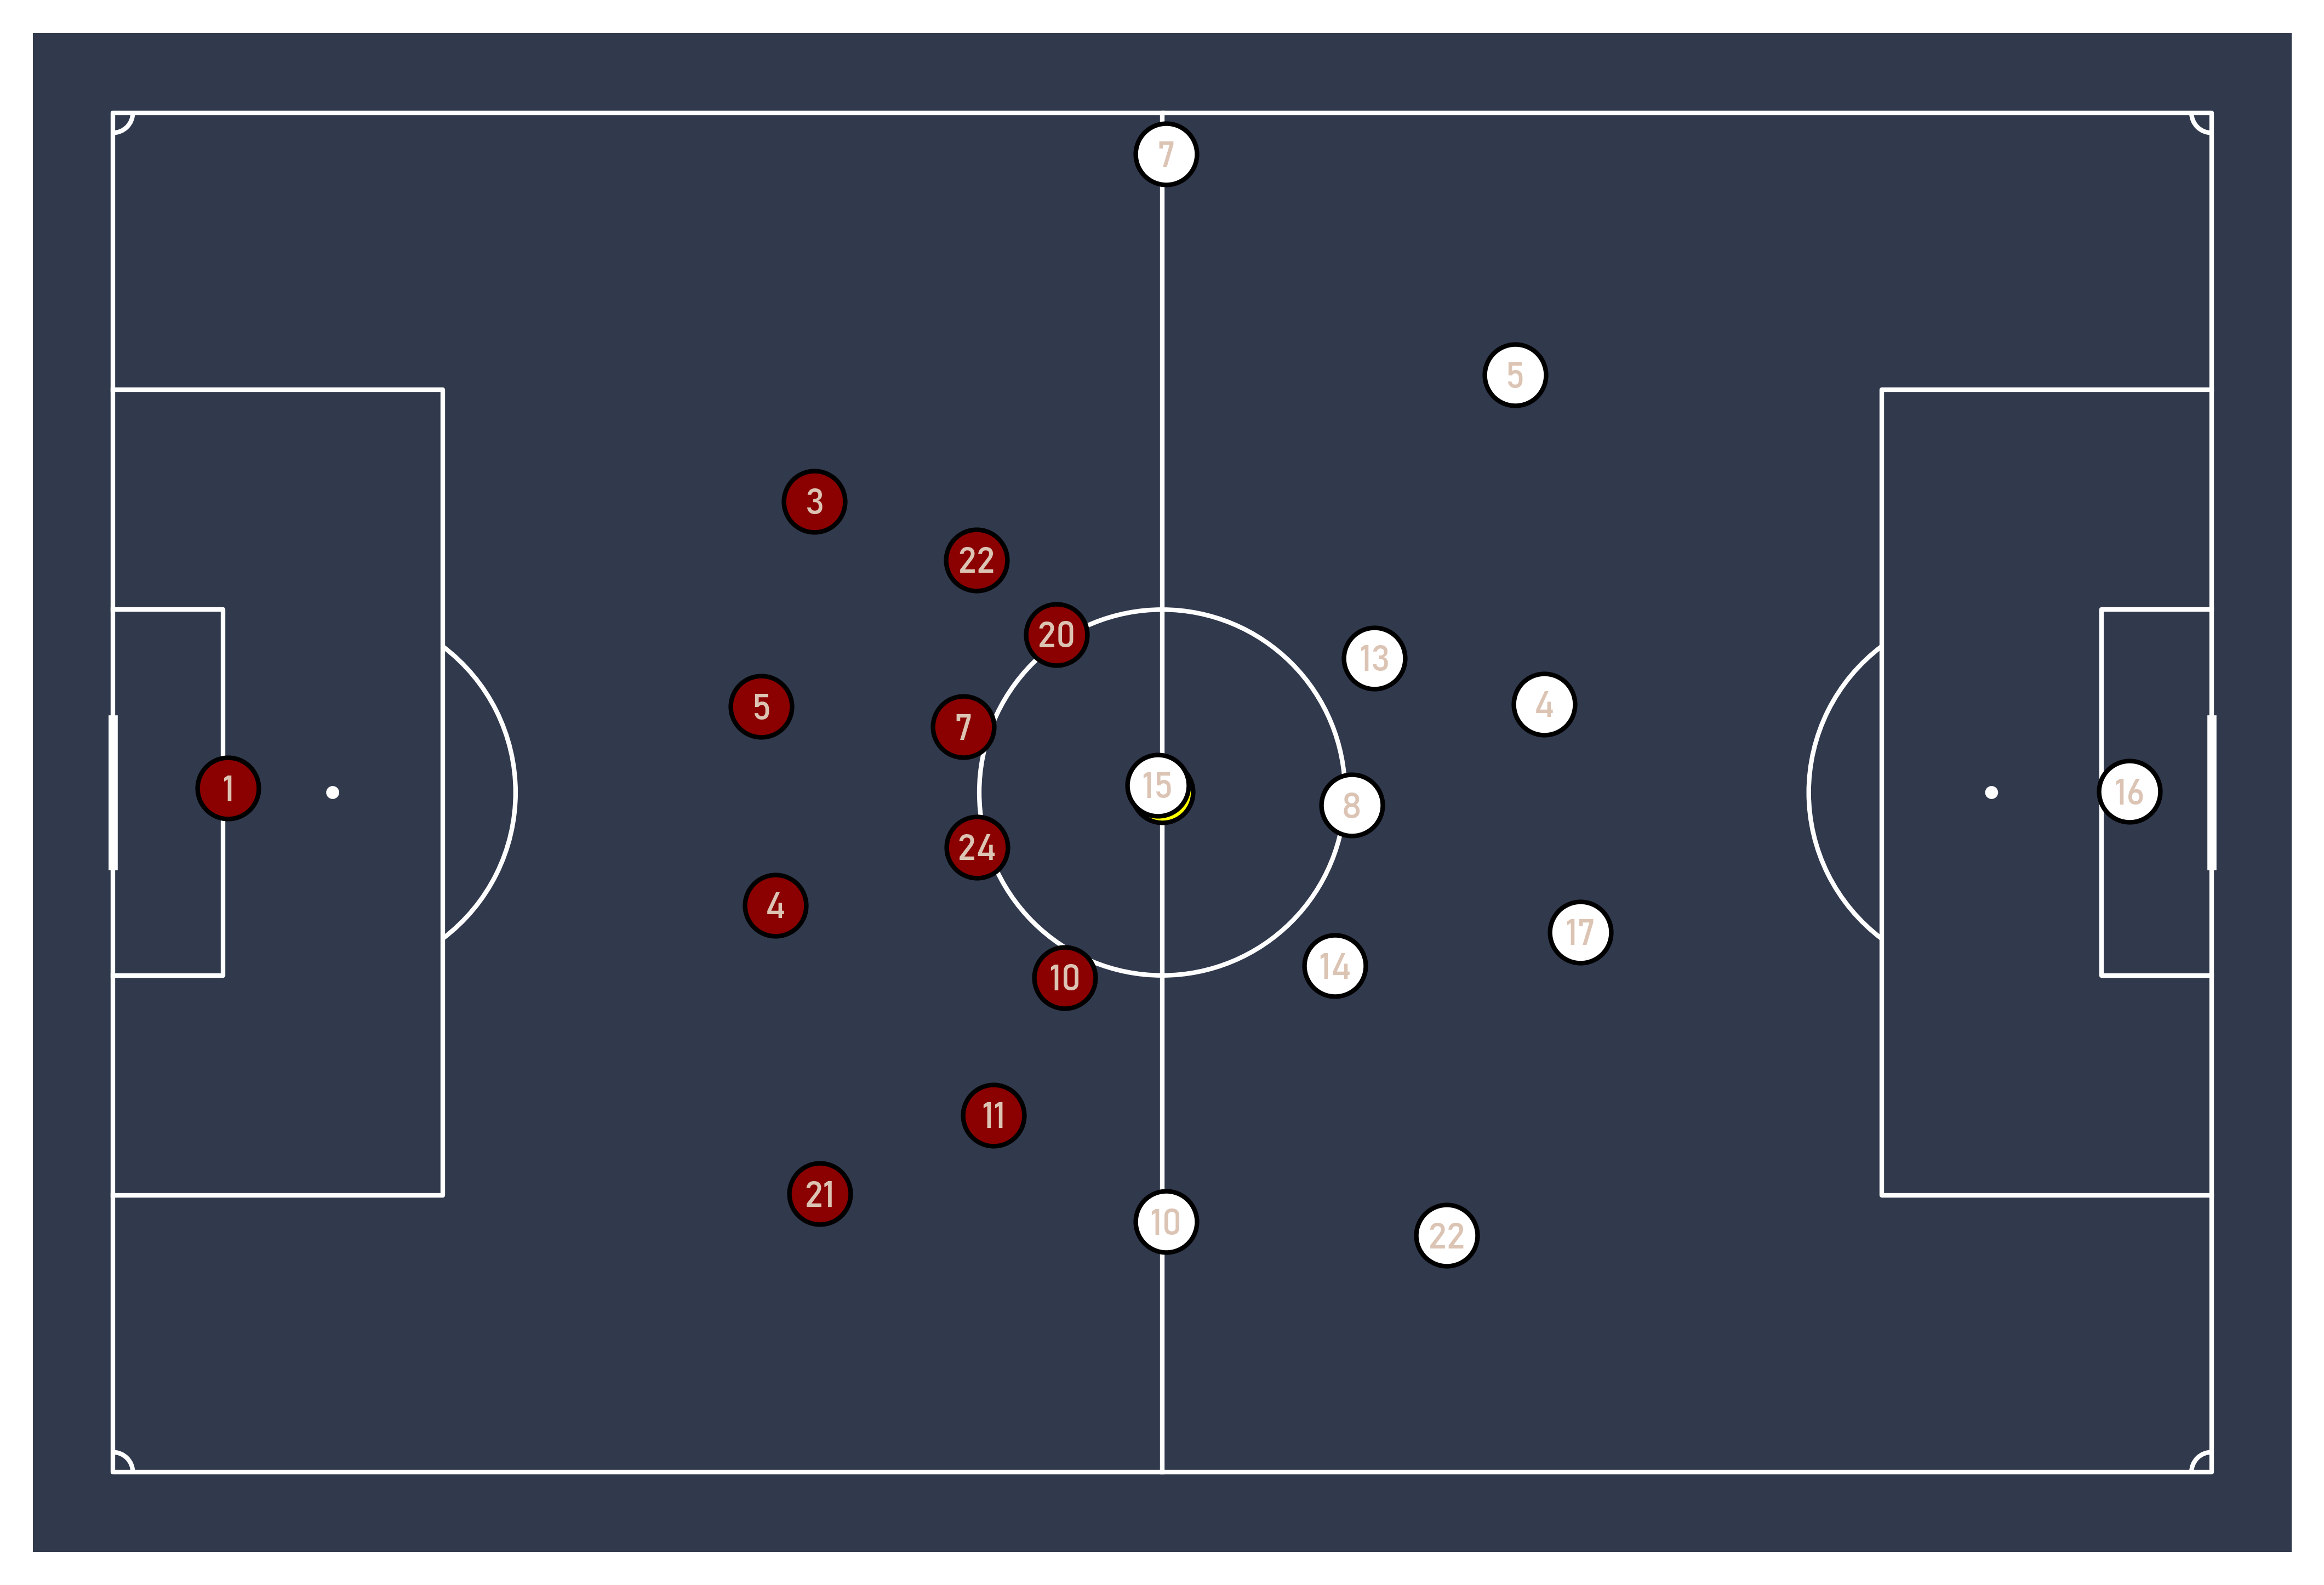

In [7]:
df_timestamp_0 = df_shifted.iloc[[0]]

player_x_columns = [col for col in df_shifted.columns if col.endswith('_x')]
player_y_columns = [col for col in df_shifted.columns if col.endswith('_y')]

pitch = Pitch(pitch_type='uefa', pitch_color='#31394d', line_color='white', linewidth=1, corner_arcs=True, line_zorder=2)
fig, ax = plt.subplots(figsize=(10, 6), dpi=600)  
pitch.draw(ax=ax) 

for col_x, col_y in zip(player_x_columns, player_y_columns):
    player_name = col_x.split('_x')[0].replace("home_", "").replace("away_", "")
    x_coord = df_timestamp_0[col_x].values[0]  
    y_coord = df_timestamp_0[col_y].values[0] 

    if pd.notna(x_coord) and pd.notna(y_coord):
        dot_color = 'white' if col_x.startswith('home') else '#8B0000' if col_x.startswith('away') else 'yellow'

        pitch.scatter(x_coord, y_coord, color=dot_color, edgecolors="black", ax=ax, s=180, zorder=3)

        player_number = player_mapping.get(player_name, "")

        ax.text(x_coord, y_coord, str(player_number), color='#dcc4b4', fontsize=8, fontweight="bold", ha='center', va='center_baseline', zorder=4)

plt.show()

## Event Data

In [8]:
df_event = pd.read_pickle('bel_fra_events.pkl')

In [9]:
# Split location feature in two colums
df_event['location_x'] = df_event['location'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else None)
df_event['location_y'] = df_event['location'].apply(lambda x: x[1] if isinstance(x, (list, np.ndarray)) else None)

# Rescale from 120x80 to 105x68 and switch direction
df_event['location_x'] = (df_event['location_x'] * 105 / 120) 
df_event['location_y'] = 68 - (df_event['location_y'] * 68 / 80)

# Same for pass end location
df_event['pass_end_location_x'] =df_event['pass_end_location'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else None)
df_event['pass_end_location_y'] =df_event['pass_end_location'].apply(lambda x: x[1] if isinstance(x, (list, np.ndarray)) else None)

df_event['pass_end_location_x'] = (df_event['pass_end_location_x'] * 105 / 120)
df_event['pass_end_location_y'] = 68 - (df_event['pass_end_location_y'] * 68 / 80)

# 1) Defensive Behavior

## Defensive Phase

Here is the defensive behavior when France has the ball on the Belgium defensive third. The average position is computed until minute 63, time of the first substitution. I could have switched players, but the average would have been biased: Openda out - Mangala in are different roles.

In [10]:
max_time = pd.Timedelta(minutes=63)  # Before the first substitution

def average_position_belgium_defence(df, max_time):
	
	df['timestamp'] = pd.to_timedelta(df['timestamp']) # Convert to timedelta
	
	df_filtered = df_shifted[(df_shifted['ball_state'] == 'In') & (df_shifted['ball_owning_team_id'] == 'France') & (df_shifted['ball_x'] < 35) & (df_shifted['timestamp'] < max_time)]
	# Ball is in play, France is owning the ball, and the ball is on the Belgium defensive third 
	
	average_positions = {}
	std_positions = {}

	player_x_columns_away = [col for col in df_filtered.columns if col.startswith('away_') and col.endswith('_x')]
	player_y_columns_away = [col for col in df_filtered.columns if col.startswith('away_') and col.endswith('_y')]

	for col_x, col_y in zip(player_x_columns_away, player_y_columns_away):
		player_name = col_x.split('_x')[0]  
		
		total_x = df_filtered[col_x].sum()
		total_y = df_filtered[col_y].sum()
		count = df_filtered[col_x].count()  
		
		if count > 0:
			avg_x = total_x / count
			avg_y = total_y / count
			std_x = df_filtered[col_x].std()
			std_y = df_filtered[col_y].std()
			average_positions[player_name] = (avg_x, avg_y)
			std_positions[player_name] = (std_x, std_y)
		else:
			average_positions[player_name] = (None, None)
			std_positions[player_name] = (None, None)
	
	return average_positions, std_positions

avg_positions, std_positions = average_position_belgium_defence(df_shifted, max_time)

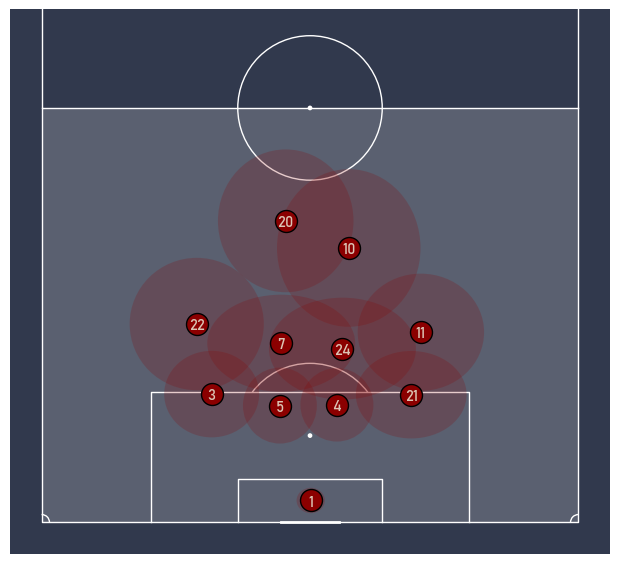

In [87]:
pitch = VerticalPitch(pitch_type='uefa',pad_top = -40, pitch_color='#31394d', line_color='white', corner_arcs=True, linewidth=1)
fig1, ax = plt.subplots(figsize=(6, 16))
pitch.draw(ax=ax)

for player, (avg_x, avg_y) in avg_positions.items():
    if avg_x is not None and avg_y is not None:
        
        player_name = player.replace("home_", "").replace("away_", "")
        
        pitch.scatter(avg_x, avg_y, color='#8B0000', s=250, edgecolors='black', label=player_name, ax=ax, zorder=3)
        
        std_x, std_y = std_positions[player]  # Get standard deviations for x and y
        
        ellipse = patches.Ellipse((avg_y, avg_x), width=std_y*1.7, height=std_x*1.7, 
                                  edgecolor='none', facecolor='#8B0000', alpha=0.20, linewidth=2, zorder=2)
        ax.add_patch(ellipse)
  
        player_number = player_mapping.get(player_name, "")  
        ax.text(avg_y, avg_x, str(player_number), color='#dcc4b4', fontsize=11, fontweight="bold", 
                ha='center', va='center_baseline', zorder=4)

box = patches.Rectangle((0, 0), 68, 52.5, linewidth=0, edgecolor='none', facecolor='white', alpha=0.2)
ax.add_patch(box)

plt.tight_layout(pad=0) 
plt.savefig("defensive_shape.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

## Negative Transitions

The goal of this function and visualization is to analyze what happens when the ball is lost in the offensive third. The plot shows the average positions of players at the moment the ball is lost, as well as their average positions after a specific window of time.

Pseudocode:

1. Filter df for:
   - ball_state == 'In' and ball_x > 52.5 (France half)
   
2. Find rows where France gains possession (previous row was Belgium possession)

3. For each Belgium player:
   - Compute average position at possession change
   - Compute average position after time_threshold seconds from the complete dataset (when ball in)

4. Return average positions when ball is lost and after time_threshold for each player



In [88]:
def average_position_belgium_transitions(df, max_time, time_threshold):
    
    df = df.copy()
    df['timestamp'] = pd.to_timedelta(df['timestamp']) 
    df['previous_possession'] = df['ball_owning_team_id'].shift(1)
    
    df_filtered = df.loc[(df['ball_state'] == 'In') & (df['timestamp'] < max_time)].copy()
    
    # Identify transition events: Belgium loses the ball to France in the offensive third
    df_filtered['ball_lost_by_belgium'] = ((df_filtered['previous_possession'] == 'Belgium') & 
    (df_filtered['ball_owning_team_id'] == 'France') & (df_filtered['ball_x'] > 52.5) )
    
    player_x_cols = [col for col in df_filtered.columns if col.startswith('away_') and col.endswith('_x')]
    player_y_cols = [col.replace('_x', '_y') for col in player_x_cols]
    player_cols = list(zip(player_x_cols, player_y_cols))
    
    # Average positions at ball loss
    df_lost = df_filtered[df_filtered['ball_lost_by_belgium']]
    average_positions = {
        col_x.split('_x')[0]: (df_lost[col_x].mean(), df_lost[col_y].mean())
        for col_x, col_y in player_cols
    }
    
    # Future average positions
    future_positions = {player: [] for player in average_positions}
    
    for _, row in df_lost.iterrows():
        future_time = row['timestamp'] + pd.Timedelta(seconds=time_threshold)
        df_future = df_filtered[(df_filtered['ball_owning_team_id'] == 'France') &
                                (df_filtered['timestamp'] == future_time)]
        
        for col_x, col_y in player_cols:
            player_name = col_x.split('_x')[0]
            if not df_future.empty:
                future_positions[player_name].append((df_future[col_x].mean(), df_future[col_y].mean()))
            else:
                future_positions[player_name].append((None, None))
    
    # Mean future positions
    average_positions_future = {
        player: (pd.Series([x for x, y in pos if x is not None]).mean(),
                 pd.Series([y for x, y in pos if y is not None]).mean())
        if any(x is not None for x, y in pos) else (None, None)
        for player, pos in future_positions.items()
    }
    
    return average_positions, average_positions_future

max_time = pd.Timedelta(minutes=63)
a, b = average_position_belgium_transitions(df_shifted, max_time, 2)

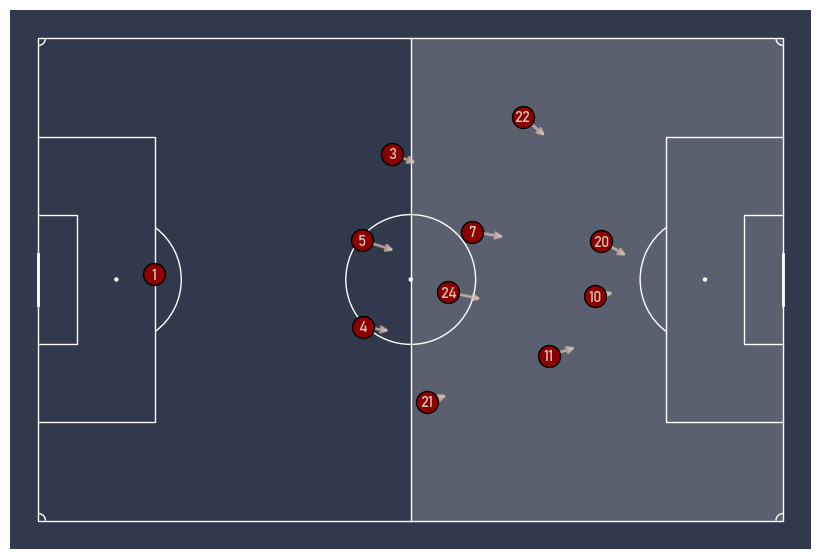

In [89]:
pitch = Pitch(pitch_type='uefa', pitch_color='#31394d', line_color='white', linewidth=1, corner_arcs=True, line_zorder=2)
fig, ax = plt.subplots(figsize=(12, 7))  
pitch.draw(ax=ax)

box = patches.Rectangle((52.5, 0), 52.5, 68, linewidth=0, edgecolor='none', facecolor='white', alpha=0.2)
ax.add_patch(box)

for col_x in a.keys():
    player_name = col_x.split('_x')[0].replace("home_", "").replace("away_", "") 
    x_a, y_a = a[col_x]

    if np.isfinite(x_a) and np.isfinite(y_a):
        x_b, y_b = b.get(col_x, (None, None))

        if np.isfinite(x_b) and np.isfinite(y_b):
            pitch.annotate('', xy=(x_b, y_b), xytext=(x_a, y_a),
                           arrowprops=dict(facecolor='orange', edgecolor='#dcc4b4', alpha=0.7, lw=2, arrowstyle='->'),
                           ax=ax)

        pitch.scatter(x_a, y_a, color='#8B0000', s=250, edgecolors='black', ax=ax, zorder=3)

        player_number = player_mapping.get(player_name, "")
        ax.text(x_a, y_a, str(player_number), color='#dcc4b4', fontsize=11, fontweight="bold", ha='center', va='center_baseline', zorder=4)

plt.savefig("transitions.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()


The plot suggests a certain tendency to pressing to the middle when the ball is lost in opponent's half after 2 seconds.

# 2) Field Control

## Pitch Control Index

The idea is to utilize the concept of nearest neighbors and Voronoi diagrams to calculate, at each timestamp, the proportion of the pitch controlled by each team. This initial approach considers only the current positions of players to determine the nearest neighbor, without accounting for their velocity or direction.

In [ ]:

def is_valid_point(p):
    return isinstance(p, (list, tuple)) and len(p) == 2 and all(isinstance(c, (int, float)) and not math.isnan(c) for c in p)

def constrained_voronoi(teams_dict, envelope):
    home_players = [p for p in teams_dict['home'] if is_valid_point(p)]
    away_players = [p for p in teams_dict['away'] if is_valid_point(p)]
    all_points = home_players + away_players
    
    # Filter out duplicate points to avoid errors
    unique_points = list(set(all_points))
    
    point_geoms = [Point(p) for p in unique_points]
    
    # Generate Voronoi diagram. Envelope = pitch boundaries
    voronoi = voronoi_diagram(MultiPoint(point_geoms), envelope=envelope, edges=False)
    
    # Assign colors
    colors = ['red'] * len(home_players) + ['blue'] * len(away_players)
    point_to_color = {tuple(p): c for p, c in zip(all_points, colors)}
    
    clipped_voronoi = []
    cell_colors = []
    
    for poly in voronoi.geoms:
        centroid = poly.centroid
        closest_point = min(all_points, key=lambda p: centroid.distance(Point(p)))
        color = point_to_color.get(tuple(closest_point), 'gray')
        
        clipped = poly.intersection(envelope)
        if not clipped.is_empty and clipped.geom_type in ['Polygon', 'MultiPolygon']:
            clipped_voronoi.append(clipped)
            cell_colors.append(color)
    
    total_area = envelope.area
    blue_areas = [poly.area for poly, color in zip(clipped_voronoi, cell_colors) if color == 'blue']
    blue_area = sum(blue_areas)
    
    blue_percentage = (blue_area / total_area) * 100
    return blue_percentage


In [91]:
def dataset_to_timeserie(df):
    result = []
    timestamps = []
    
    # Define football pitch boundaries
    envelope = Polygon([(0, 0), (105, 0), (105, 68), (0, 68)])

    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
    if 'timestamp' not in df.columns:
        raise ValueError("DataFrame must contain 'timestamp' column")
    
    progress_bar = tqdm(total=len(df) // 10, desc="Processing rows", unit="row")
    
    try:
        for i in range(0, len(df), 10):
            row = df.iloc[i]

            if pd.isna(row['timestamp']):
                result.append(np.nan)
                progress_bar.update(1)
                continue

            timestamps.append(row['timestamp'])
            home_players = defaultdict(dict)
            away_players = defaultdict(dict)

            for col in row.index:
                if col.startswith(('home_', 'away_')):
                    parts = col.split('_')
                    team = parts[0]
                    coord_type = parts[-1]

                    if coord_type not in ('x', 'y'):
                        continue

                    player_name = '_'.join(parts[1:-1])
                    target_dict = home_players if team == 'home' else away_players
                    target_dict[player_name][coord_type] = row[col]

            # Filter valid coordinates
            filtered_home = [
                (float(coords['x']), float(coords['y']))
                for coords in home_players.values()
                if {'x', 'y'}.issubset(coords) and pd.notna(coords['x']) and pd.notna(coords['y'])
            ]

            filtered_away = [
                (float(coords['x']), float(coords['y']))
                for coords in away_players.values()
                if {'x', 'y'}.issubset(coords) and pd.notna(coords['x']) and pd.notna(coords['y'])
            ]

            if len(filtered_home) + len(filtered_away) < 2:
                print(f"Skipping timestamp {row['timestamp']} — not enough valid points.")
                result.append(np.nan)
                progress_bar.update(1)
                continue

            position_dict = {'home': filtered_home, 'away': filtered_away}

            try:
                blue_percentage = constrained_voronoi(position_dict, envelope)
                result.append(blue_percentage)
            except Exception as e:
                print(f"Error at timestamp {row['timestamp']}: {str(e)}")
                print(f"Home: {filtered_home}")
                print(f"Away: {filtered_away}")
                result.append(np.nan)

            progress_bar.update(1)

    finally:
        progress_bar.close()

    return timestamps, result


In [92]:
# Run the function on the entire dataset
timestamps, percentages = dataset_to_timeserie(df_shifted) 

Processing rows:   0%|          | 0/13039 [00:00<?, ?row/s]

In [93]:
def percent_formatter(x, pos):
    return f'{x:.0f}%'

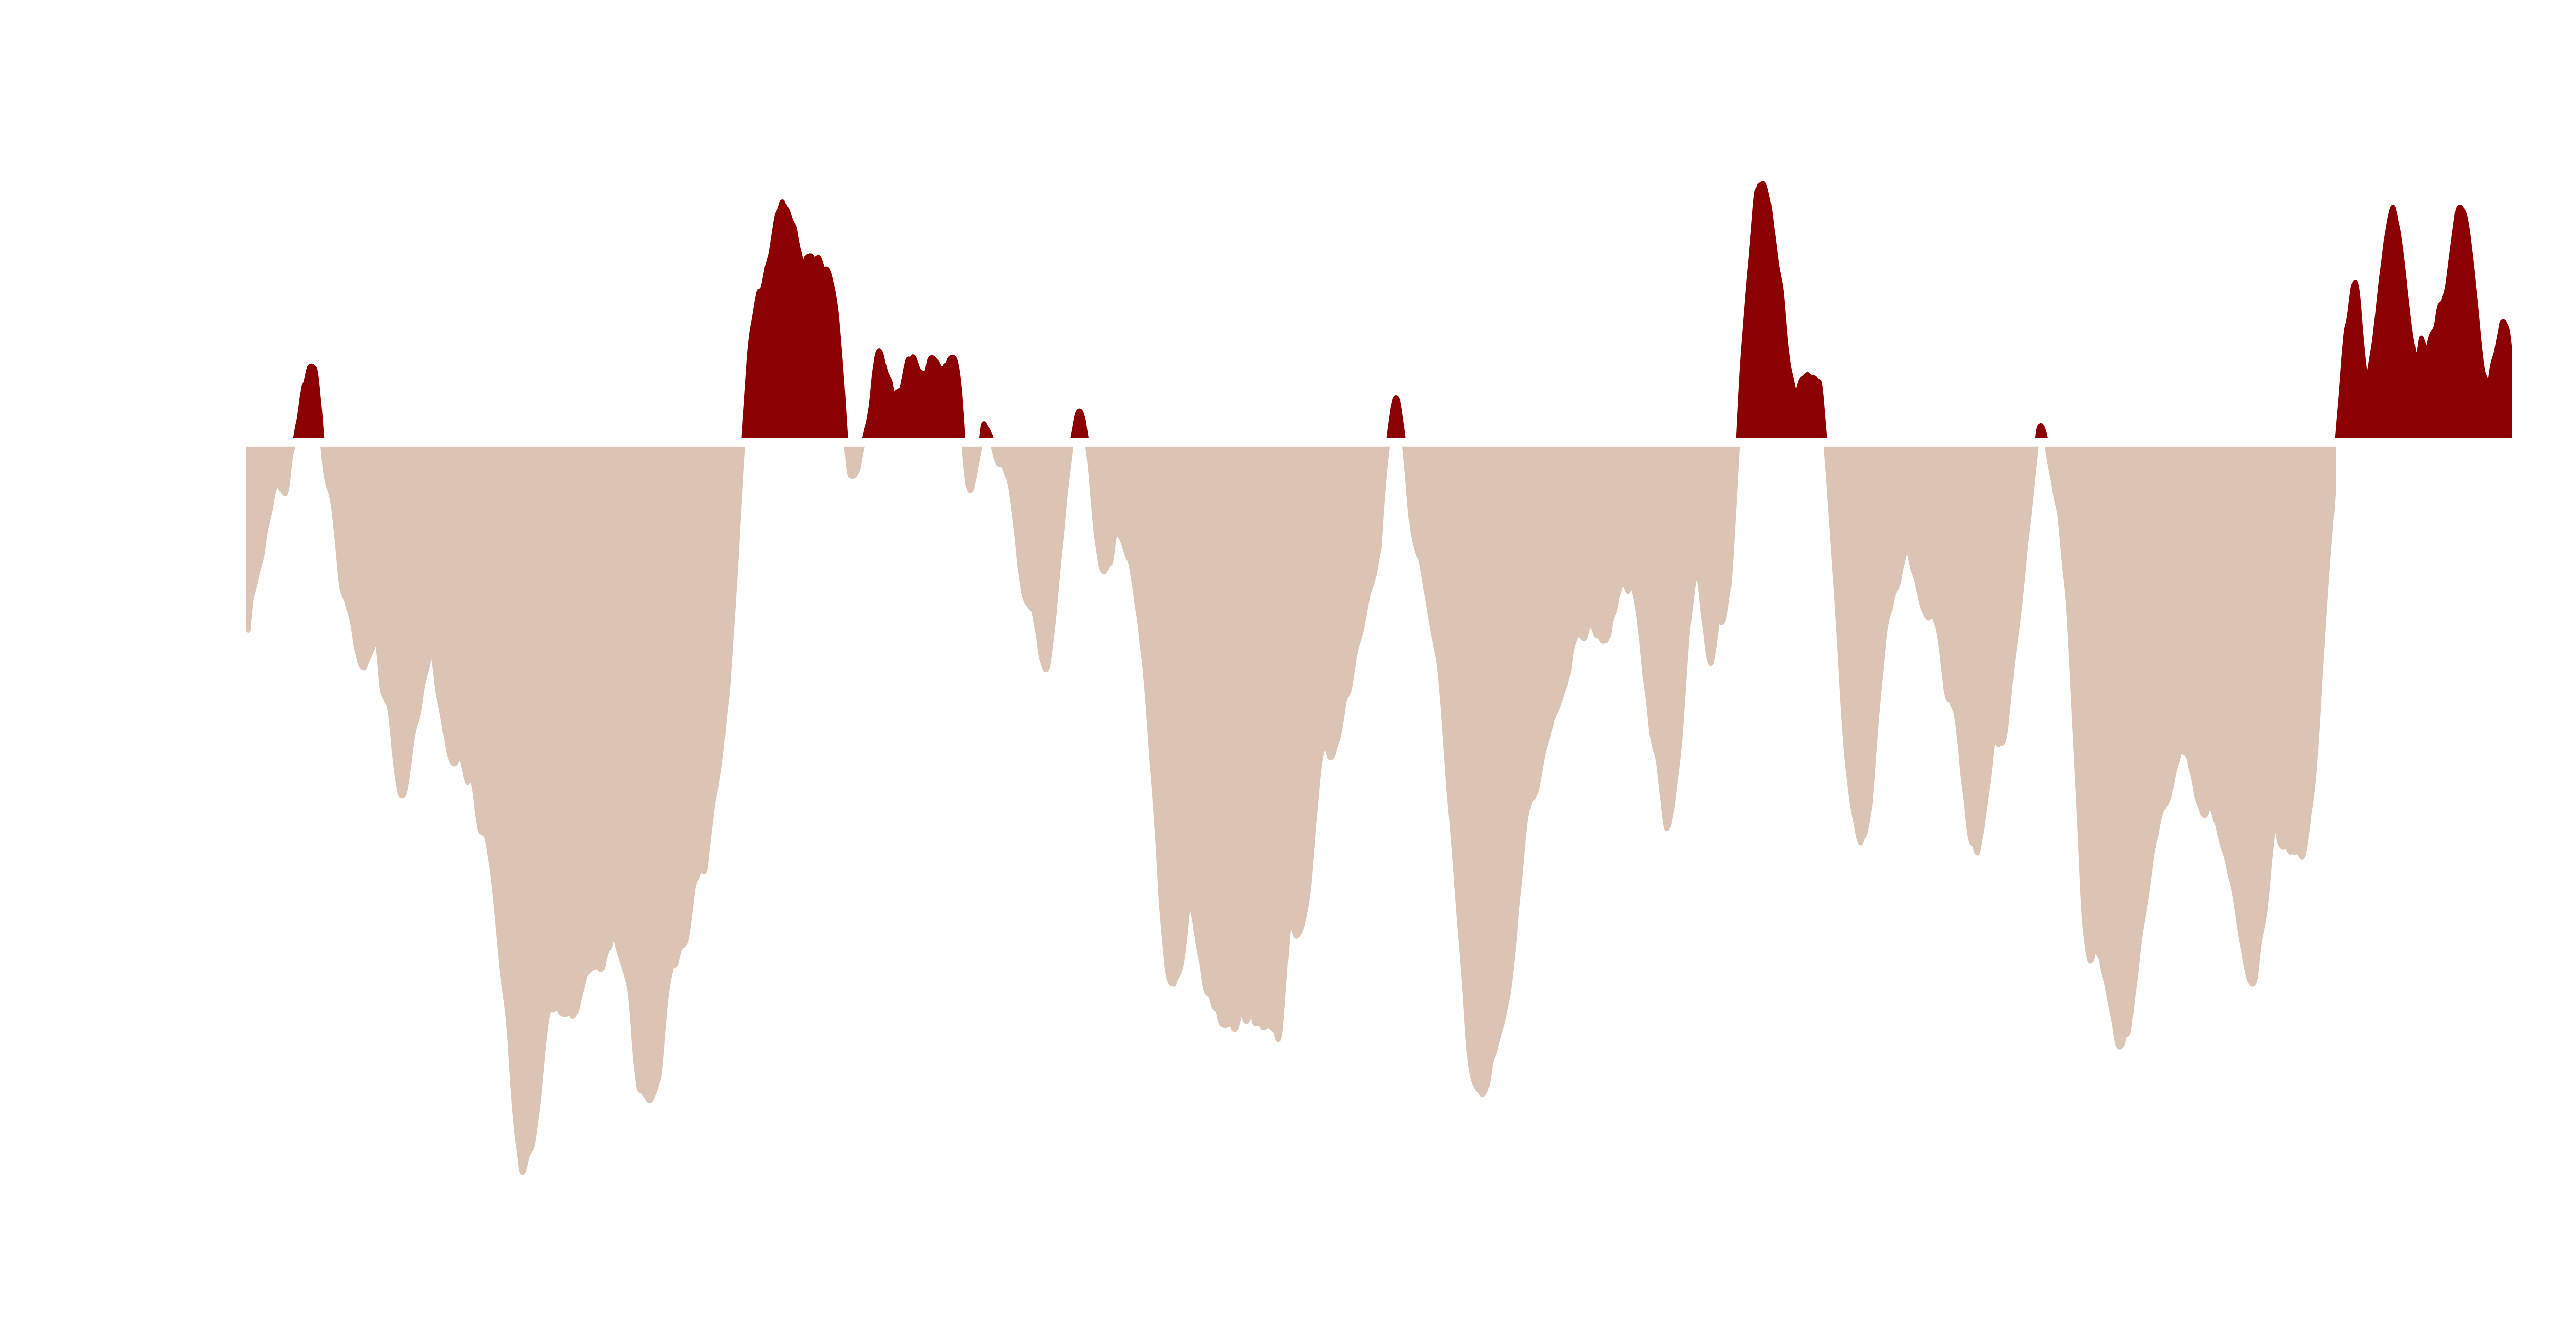

In [108]:
window_size = 500
smooth_percentages = np.convolve(percentages, np.ones(window_size)/window_size, mode='valid')
timestamps_in_minutes_extended = np.linspace(0, 90, len(percentages))

plt.figure(figsize=(10, 5), facecolor='none', dpi=600)
plt.plot(timestamps_in_minutes_extended[window_size-1:], smooth_percentages, color='White', linewidth=0)
plt.axhline(y=50, color='white', linestyle='-', linewidth=2)
plt.vlines(x=83.5, ymin=25, ymax=50, color='White', linestyle='--', linewidth=3)

plt.fill_between(timestamps_in_minutes_extended[window_size-1:], smooth_percentages, 50, 
                 where=(smooth_percentages >= 50), color='#8B0000', alpha=1)
plt.fill_between(timestamps_in_minutes_extended[window_size-1:], smooth_percentages, 50, 
                 where=(smooth_percentages < 50), color='#dcc4b4', alpha=1)

ax = plt.gca()
ax.set_facecolor('none')

for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='both', which='both', length=0, colors='white',labelsize=15)     

ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax.set_xticks([t for t in np.linspace(0, 90, num=7) if t > 0])  # Adjust 'num' to control tick density
ax.set_yticks([25, 35, 50, 65])
plt.xlim(0, 90)

plt.savefig('pitch_control_visualization.png', transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

## Heatmap

Heatmap of ball receipts for Belgium:

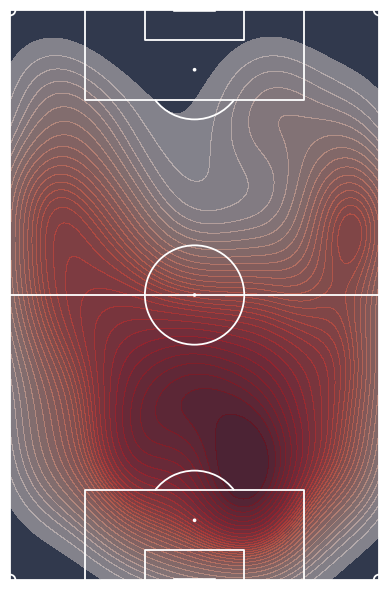

In [95]:
belgium_receipts = df_event[(df_event['type'] == 'Ball Receipt*') & (df_event['possession_team'] == 'Belgium')]

pitch = VerticalPitch(pitch_type='uefa', pitch_color='#31394d', line_color='white', linewidth=1.3, corner_arcs=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(10, 6))

sns.kdeplot(
    y=belgium_receipts['location_x'],
    x=belgium_receipts['location_y'],
    fill=True, cmap='Reds', levels=30, alpha=0.4, ax=ax,  
)

plt.xlim(0, 68)
plt.ylim(0, 105)

plt.show()

# save as png
fig.savefig('belgium_heatmap.png', dpi=600, bbox_inches='tight', facecolor='#31394d')

# 3) Offensive Behavior

## Shot Map

In [96]:
shots = df_event[(df_event['type'] == 'Shot') & (df_event['possession_team'] == 'Belgium')]
shots = shots[['timestamp', 'location_x', 'location_y', 'player', 'shot_body_part', 'shot_deflected', 'shot_end_location', 'shot_key_pass_id', 'shot_outcome', 'shot_statsbomb_xg', 'shot_type' ]]

In [97]:
shots

,timestamp,location_x,location_y,player,shot_body_part,shot_deflected,shot_end_location,shot_key_pass_id,shot_outcome,shot_statsbomb_xg,shot_type
170281,00:26:11.821,93.1875,30.600,Yannick Ferreira Carrasco,Left Foot,None,"[109.4, 43.3]",None,Blocked,0.105909,Open Play
170291,00:15:23.814,97.1250,24.225,Yannick Ferreira Carrasco,Right Foot,None,"[111.5, 50.9]",0158676d-fb9e-4dd5-8c06-f5cd003627af,Blocked,0.130748,Open Play
170294,00:25:02.703,96.0750,46.155,Romelu Lukaku Menama,Left Foot,True,"[117.0, 36.5, 1.3]",009d5fa4-eaeb-43c6-a370-7c1105822c2a,Saved,0.038119,Open Play
170297,00:37:09.654,88.2000,41.565,Kevin De Bruyne,Right Foot,None,"[115.8, 38.2, 1.3]",5241fa68-1ffa-4cde-b3f6-0634af8572b9,Saved,0.082714,Open Play
170299,00:44:40.077,77.6125,45.475,Arthur Theate,Left Foot,None,"[92.9, 28.3]",None,Wayward,0.005724,Open Play


In [ ]:
total_shots = len(shots)
total_goals = len(shots[shots['shot_outcome'] == 'Goal'])
total_xg = shots['shot_statsbomb_xg'].sum()
xg_per_shot = total_xg / total_shots

shots['distance_to_goal'] = np.sqrt((shots['location_x'] - 105)**2 + (shots['location_y'] - 34)**2)

# Compute the average shot distance
average_shot_distance = shots['distance_to_goal'].mean()


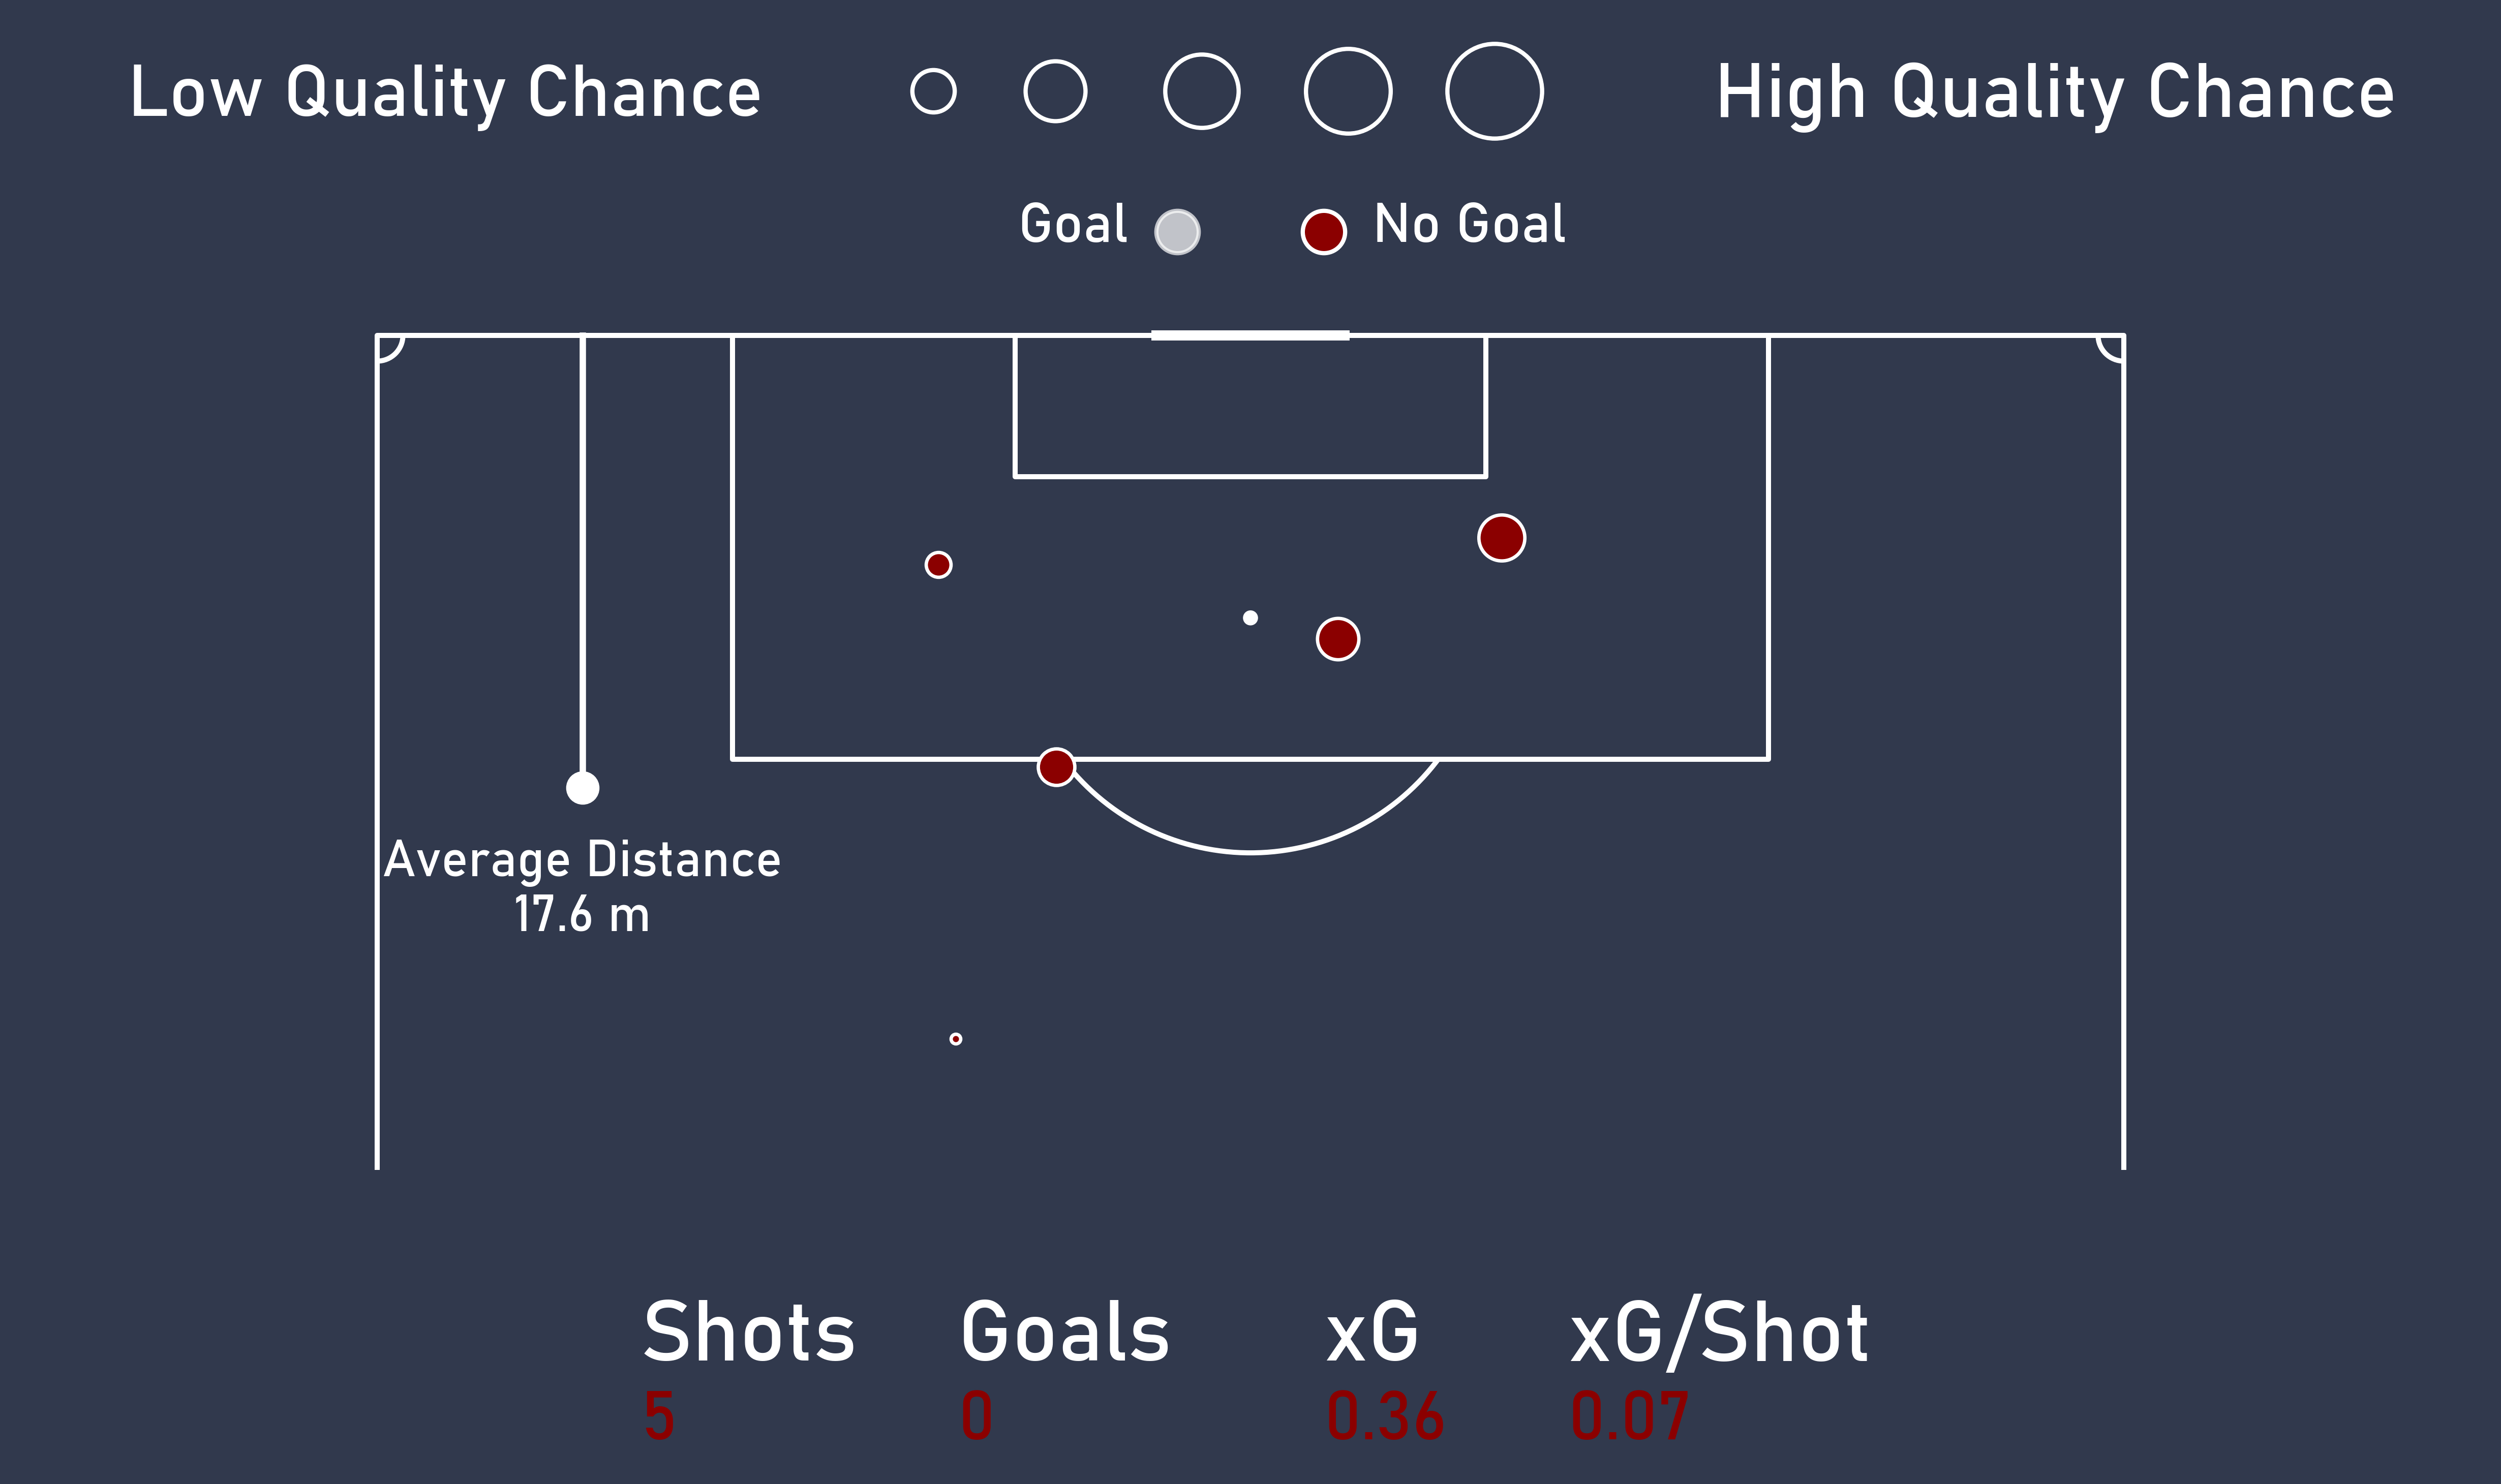

In [110]:
fig_shots = plt.figure(figsize=(8, 11), dpi=600)
fig_shots.patch.set_facecolor('#31394d')

ax1 = fig_shots.add_axes([0, 0.55, 1, 0.1])
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off') 

ax1.text(0.17, 0.8, 'Low Quality Chance', fontsize=17, color='white', ha='center', va='center', fontname='Bahnschrift')

ax1.scatter(0.37, 0.82, s=100, color = '#31394d', edgecolors='white', linewidth=1)
ax1.scatter(0.42, 0.82, s=200, color = '#31394d', edgecolors='white', linewidth=1)
ax1.scatter(0.48, 0.82, s=300, color = '#31394d', edgecolors='white', linewidth=1)
ax1.scatter(0.54, 0.82, s=400, color = '#31394d', edgecolors='white', linewidth=1)
ax1.scatter(0.6, 0.82, s=500, color = '#31394d', edgecolors='white', linewidth=1)


ax1.text(0.83, 0.8, 'High Quality Chance', fontsize=18, color='white', ha='center', va='center', fontname='Bahnschrift')

ax1.text(
    x=0.45, 
    y=0.37, 
    s=f'Goal', 
    fontsize=13, 
    fontproperties='Bahnschrift', 
    color='white', 
    ha='right'
)
ax1.scatter(
    x=0.47, 
    y=0.4, 
    s=100, 
    color='white', 
    edgecolor='white', 
    linewidth=1,
    alpha=.7
)


ax1.scatter(
    x=0.53, 
    y=0.4, 
    s=100, 
    color='#8b0000', 
    edgecolor='white', 
    linewidth=1
)

ax1.text(
    x=0.55, 
    y=0.37, 
    s=f'No Goal', 
    fontsize=13, 
    fontproperties='Bahnschrift', 
    color='white', 
    ha='left'
)

ax2 = fig_shots.add_axes([0.1, 0.30, 0.8, 0.3])
ax2.set_facecolor('#31394d')
ax2.axis('off')  # Hide axes

pitch = VerticalPitch(pitch_type='uefa', half=True, pitch_color='#31394d', line_color='white', linewidth=1.2, corner_arcs=True, axis=True, label=True,  pad_bottom=-20)
pitch.draw(ax=ax2)

ax2.scatter(x=60, y=105-average_shot_distance, s=50, linewidth=.8, color='white')
ax2.plot([60, 60], [(105-average_shot_distance), 105], color='white', linewidth=1.5)
ax2.text(60, 105-average_shot_distance-4, f'Average Distance\n{average_shot_distance:.1f} m', fontsize=12, color='white', ha='center', va='center', fontname='Bahnschrift')

for x in shots.to_dict(orient='records'):
	pitch.scatter(x['location_x'], x['location_y'], color='#8b0000', edgecolors='White', linewidth=0.8, s=900*x['shot_statsbomb_xg'], ax=ax2)

ax3 = fig_shots.add_axes([0, 0.23, 1, 0.05])
ax3.set_facecolor('#31394d')
ax3.axis('off') 

ax3.text(0.25,0.6,s='Shots',fontsize=20,color='white',ha='left',va='center',fontname='Bahnschrift')
ax3.text(0.25,0,s=f'{total_shots}',fontsize=16,color='#8b0000',ha='left',fontname='Bahnschrift',fontweight='bold')

ax3.text(0.38,0.6,s='Goals',fontsize=20,color='white',ha='left',va='center',fontname='Bahnschrift')
ax3.text(0.38,0,s=f'{total_goals}',fontsize=16,color='#8b0000',ha='left',fontname='Bahnschrift', fontweight='bold')

ax3.text(0.53,0.6,s='xG',fontsize=20,color='white',ha='left',va='center',fontname='Bahnschrift')
ax3.text(0.53,0,s=f'{total_xg:.2f}',fontsize=16,color='#8b0000',ha='left',fontname='Bahnschrift', fontweight='bold')

ax3.text(0.63,0.6,s='xG/Shot',fontsize=20,color='white',ha='left',va='center',fontname='Bahnschrift')
ax3.text(0.63,0,s=f'{xg_per_shot:.2f}',fontsize=16,color='#8b0000',ha='left',fontname='Bahnschrift', fontweight='bold')


plt.savefig('belgium_shots.png', dpi=600, facecolor='#31394d', bbox_inches='tight')
plt.show()

## Main Passes Map

The idea is to divide the pitch in smaller squared areas, then count the number of passes from each area to others, in order to identify main passing trends.

In [100]:
df_passes = df_event[(df_event['type'] == 'Pass') & (df_event['possession_team'] == 'Belgium') ]

In [101]:
df_passes

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,...,tactics,team,team_id,timestamp,type,under_pressure,location_x,location_y,pass_end_location_x,pass_end_location_y
19523,None,None,None,None,None,None,None,None,None,None,...,None,Belgium,782,00:01:29.842,Pass,None,6.1250,28.390,3.4125,31.705
19524,None,None,None,None,None,None,None,None,None,None,...,None,Belgium,782,00:01:40.708,Pass,None,10.2375,36.550,20.4750,30.855
19525,None,None,None,None,None,None,None,None,None,None,...,None,Belgium,782,00:01:44.686,Pass,None,21.0875,30.855,15.7500,47.430
19526,None,None,None,None,None,None,None,None,None,None,...,None,Belgium,782,00:01:48.606,Pass,None,16.8875,48.025,22.4000,31.875
19527,None,None,None,None,None,None,None,None,None,None,...,None,Belgium,782,00:01:54.434,Pass,None,25.9000,31.025,24.2375,43.520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20665,None,None,None,None,None,None,None,None,None,None,...,None,Belgium,782,00:47:14.309,Pass,True,80.2375,41.140,81.8125,29.410
20668,None,None,None,None,None,None,None,None,None,None,...,None,Belgium,782,00:47:23.862,Pass,None,68.3375,0.000,49.7875,11.050
20669,None,None,None,None,None,None,None,None,None,None,...,None,Belgium,782,00:47:31.175,Pass,None,68.1625,17.850,96.6000,47.685
20670,None,None,None,None,None,None,None,None,None,None,...,None,France,771,00:47:33.797,Pass,None,8.4875,20.230,17.8500,11.135


In [102]:
pitch_length = 105
pitch_width = 68

x_blocks = 6
y_blocks = 5

x_bins = np.linspace(0, pitch_length, x_blocks + 1)
y_bins = np.linspace(0, pitch_width, y_blocks + 1)

# determine block coordinates
def get_block(x, y, x_bins, y_bins):
    x_block = np.digitize(x, x_bins) - 1
    y_block = np.digitize(y, y_bins) - 1
    x_block = max(0, min(x_blocks - 1, x_block))
    y_block = max(0, min(y_blocks - 1, y_block))
    return (x_block, y_block)

# Pass network matrix
pass_network = np.zeros((x_blocks * y_blocks, x_blocks * y_blocks), dtype=int)

for _, row in df_passes.iterrows():
    start_block = get_block(row['location_x'], row['location_y'], x_bins, y_bins)
    end_block = get_block(row['pass_end_location_x'], row['pass_end_location_y'], x_bins, y_bins)
    
    if start_block != end_block:
        start_idx = start_block[0] * y_blocks + start_block[1]
        end_idx = end_block[0] * y_blocks + end_block[1]
        pass_network[start_idx, end_idx] += 1

block_labels = [f"{x}_{y}" for x in range(x_blocks) for y in range(y_blocks)]
pass_network_df = pd.DataFrame(pass_network, index=block_labels, columns=block_labels)

In [103]:
pass_network_df

,0_0,0_1,0_2,0_3,0_4,1_0,1_1,1_2,1_3,1_4,...,4_0,4_1,4_2,4_3,4_4,5_0,5_1,5_2,5_3,5_4
0_0,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0_1,2,0,2,0,0,1,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0_2,1,4,0,12,1,2,1,3,2,2,...,0,0,0,0,0,0,0,0,0,0
0_3,0,1,4,0,5,0,3,1,2,5,...,0,0,0,0,0,0,0,0,0,0
0_4,0,1,0,6,0,0,0,0,0,2,...,0,0,1,0,0,0,0,0,0,0
1_0,2,1,1,0,0,0,2,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1_1,0,2,5,2,0,5,0,4,3,0,...,0,1,0,0,0,0,0,0,0,0
1_2,0,0,0,1,0,0,6,0,7,0,...,0,0,0,1,0,0,0,0,0,0
1_3,0,0,1,1,0,0,1,6,0,6,...,0,0,0,1,0,0,0,0,0,0
1_4,0,0,2,1,2,0,1,0,4,0,...,0,0,0,1,1,0,0,0,0,0


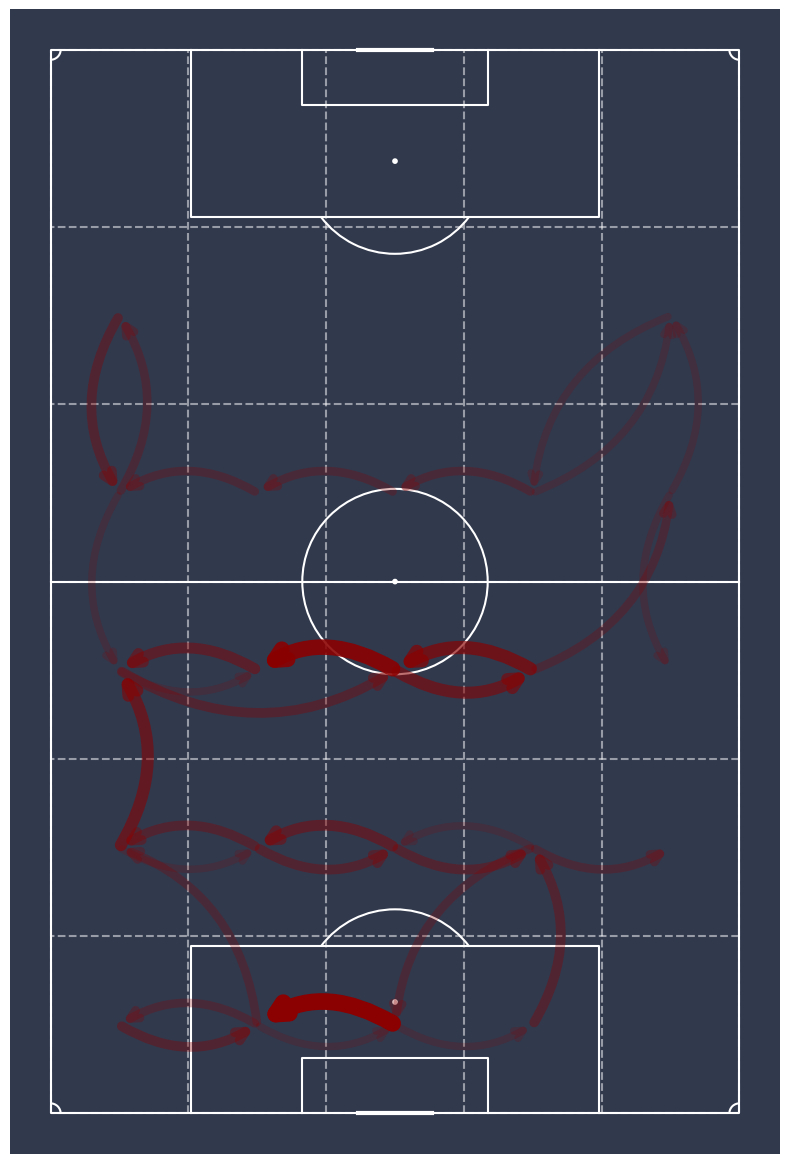

In [104]:
pitch = VerticalPitch(pitch_type='uefa', pitch_color='#31394d', line_color='white',
              linewidth=1.5, corner_arcs=True)
fig, ax = pitch.draw(figsize=(8, 12)) 

for x in x_bins:
    ax.plot([0, pitch_width], [x, x], color='white', linestyle='--', linewidth=1.5, alpha=0.5)
for y in y_bins:
    ax.plot([y, y], [0, pitch_length], color='white', linestyle='--', linewidth=1.5, alpha=0.5)

x_centers = (x_bins[:-1] + x_bins[1:]) / 2
y_centers = (y_bins[:-1] + y_bins[1:]) / 2

max_passes = np.max(pass_network)
min_passes = np.min(pass_network[pass_network > 0])
norm_alpha = plt.Normalize(vmin=min_passes, vmax=max_passes)

# Draw arrows
for i in range(x_blocks * y_blocks):
    for j in range(x_blocks * y_blocks):
        if pass_network[i, j] > 3:
           
            start_x_block = i // y_blocks
            start_y_block = i % y_blocks
            end_x_block = j // y_blocks
            end_y_block = j % y_blocks

            start_y = x_centers[start_x_block]
            start_x = y_centers[start_y_block]
            end_y = x_centers[end_x_block]
            end_x = y_centers[end_y_block]

            pass_count = pass_network[i, j]
            alpha = norm_alpha(pass_count)**1.3
            color = '#8B0000'
            width = 0.1 + 0.5 * (pass_count / max_passes)
            arrow = FancyArrowPatch(
                (start_x, start_y), (end_x, end_y),
                connectionstyle="arc3,rad=0.3",
                arrowstyle='->',
                color=color,
                alpha=alpha,
                linewidth=width * 20,
                mutation_scale=10 + 20 * width,
                zorder=3
            )
            ax.add_patch(arrow)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.tight_layout()

plt.savefig("pass_flows.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()


## Passes to the Box

In [105]:
passes_to_box = df_passes[(df_passes['pass_end_location_x'] > 88.5) & 
		  (df_passes['pass_end_location_y'] > 13.84) & 
		  (df_passes['pass_end_location_y'] < 54.16)]

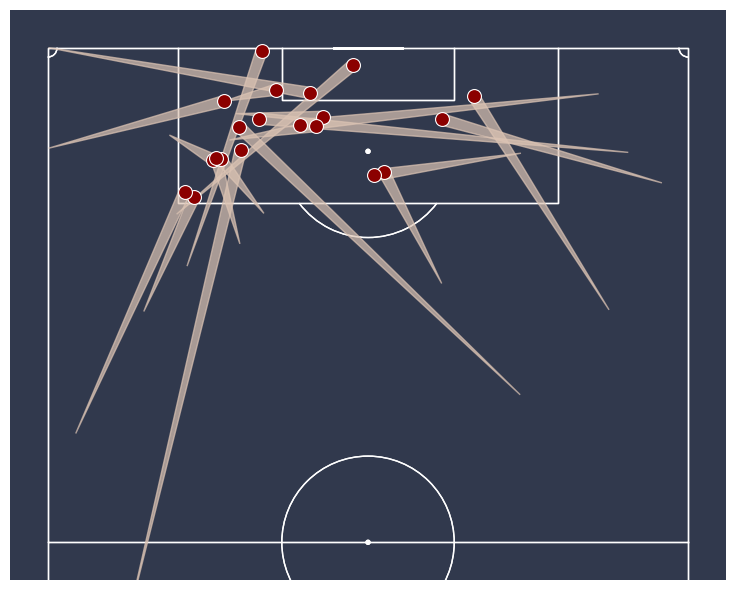

In [106]:
pitch = VerticalPitch(half=True, pitch_type='uefa', pitch_color='#31394d', line_color='white', linewidth=1, corner_arcs=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(10, 6))

for i in passes_to_box.index:
    y0 = passes_to_box['location_x'][i]  # Pass origin
    x0 = passes_to_box['location_y'][i]  # Pass origin
    y1 = passes_to_box['pass_end_location_x'][i]  # Pass destination 
    x1 = passes_to_box['pass_end_location_y'][i]  # Pass destination 
    
    # Direction vector 
    dx = x1 - x0
    dy = y1 - y0
    length = np.hypot(dx, dy)
    if length == 0:
        continue 
    
    perp_x = -dy / length
    perp_y = dx / length
    
    start_width = 0.0    # Narrow at origin
    end_width = 1.2      # Wide at destination
    
    x_start_left = x0 - perp_x * start_width / 2
    y_start_left = y0 - perp_y * start_width / 2
    x_start_right = x0 + perp_x * start_width / 2
    y_start_right = y0 + perp_y * start_width / 2
    
    x_end_left = x1 - perp_x * end_width / 2
    y_end_left = y1 - perp_y * end_width / 2
    x_end_right = x1 + perp_x * end_width / 2
    y_end_right = y1 + perp_y * end_width / 2
    
    verts = [
        (x_start_left, y_start_left),
        (x_start_right, y_start_right),
        (x_end_right, y_end_right),
        (x_end_left, y_end_left),
        (x_start_left, y_start_left)  # Close the polygon
    ]
    
    ax.add_patch(PolygonPatch(verts, closed=True, color='#dcc4b4', alpha=0.7, zorder=5))
    ax.scatter(x1, y1, color='#8b0000', edgecolors='white', linewidth=0.8, s=100, alpha=1, zorder=6)

pitch.draw(ax=ax)

plt.savefig("passes_to_box.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# Image Generation

## Final Output

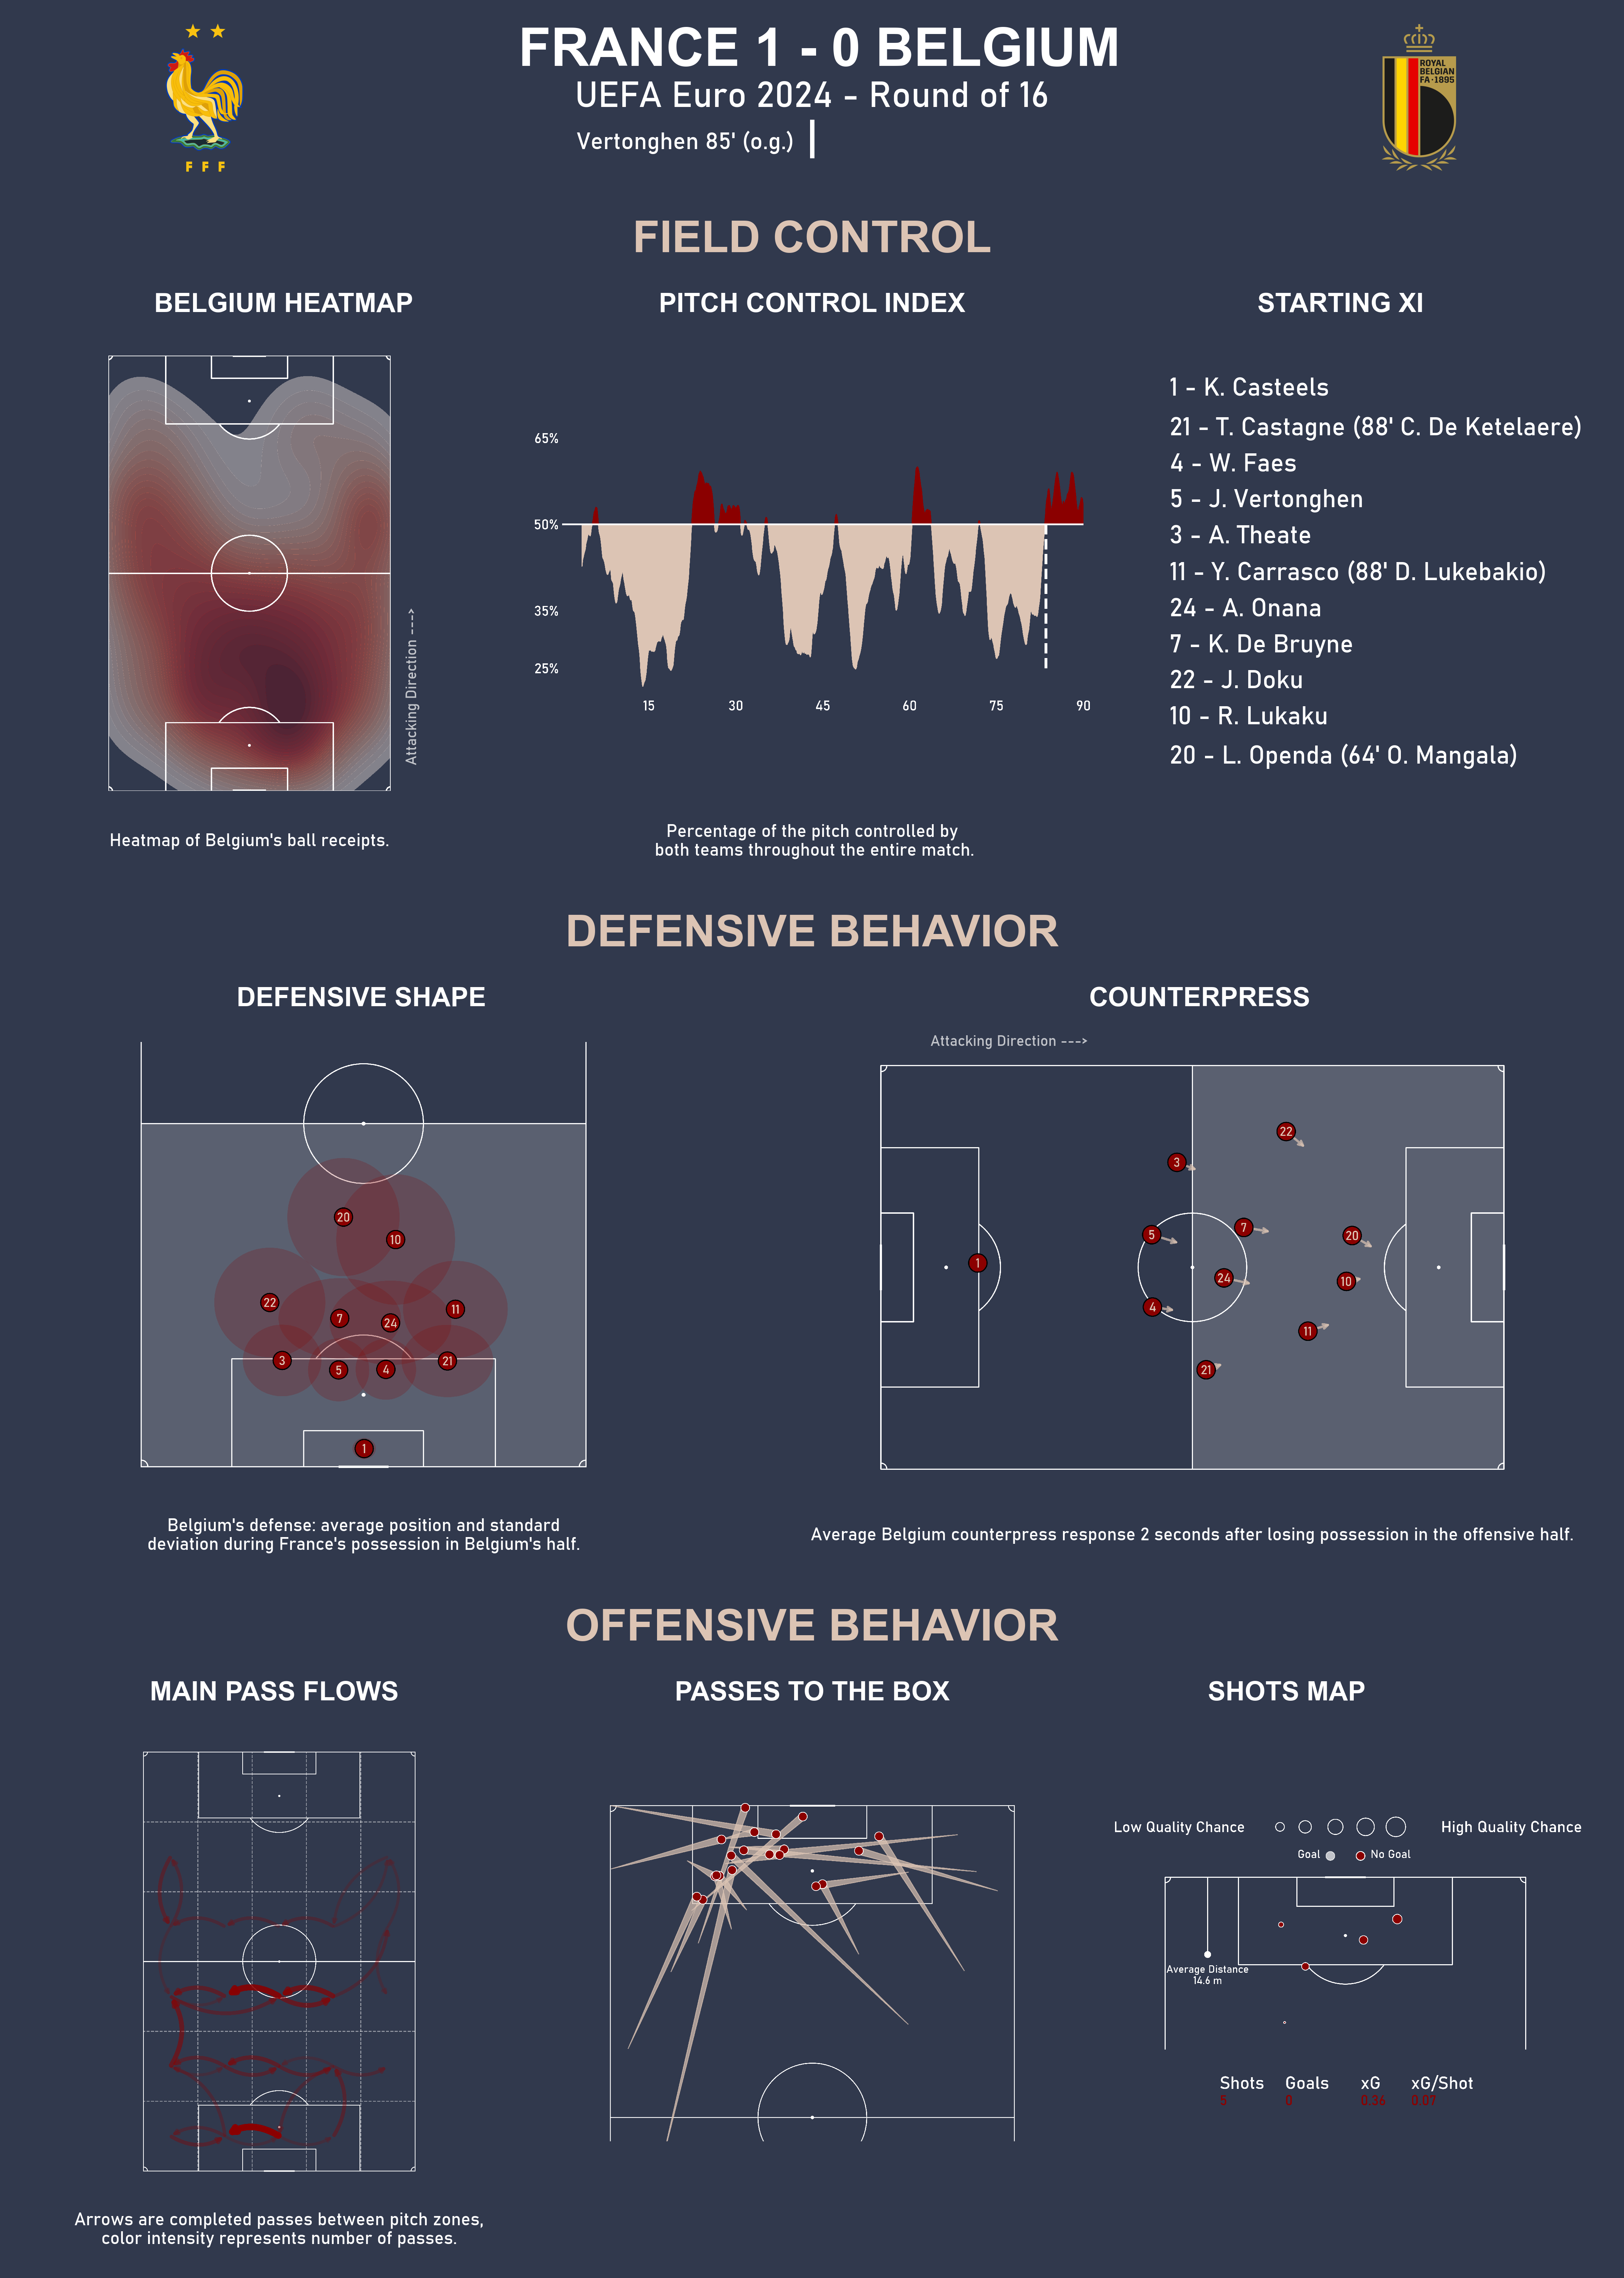

In [107]:
# ----- Custom colors and fonts -----
title_color = "#FFFFFF"
background_color = "#31394d"
text_color = "#FFFFFF"
accent_color = "#FF5733"

title_font = "Arial"
body_font = "Bahnschrift"

# Formation text
formation_text = "1 - K. Casteels\n21 - T. Castagne (88' C. De Ketelaere)\n4 - W. Faes\n5 - J. Vertonghen\n3 - A. Theate\n11 - Y. Carrasco (88' D. Lukebakio)\n24 - A. Onana\n7 - K. De Bruyne\n22 - J. Doku\n10 - R. Lukaku\n20 - L. Openda (64' O. Mangala)"

# ----- Load team logos once -----
url1 = "https://logos-world.net/wp-content/uploads/2024/06/Belgium-National-Football-Team-Logo.png"
url2 = "https://logos-world.net/wp-content/uploads/2024/06/France-National-Football-Team-Logo.png"
img1 = Image.open(BytesIO(requests.get(url1).content))
img2 = Image.open(BytesIO(requests.get(url2).content))

# ----- A4 Figure Setup -----
fig = plt.figure(figsize=(8.27, 11.69), dpi=600)
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(nrows=13, ncols=4, height_ratios=[0.17, 0.08, 0.06, 0.5, 0.06, 0.08, 0.06, 0.5, 0.06, 0.08, 0.06, 0.5, 0.06])
gs.update(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.1, wspace=0.1)


def stylize_ax(ax, border=True, grid=True):
    ax.set_facecolor(background_color)
    ax.set_xticks([])
    ax.set_yticks([])
    if grid:
        ax.grid(True, color='white', linestyle='-', linewidth=0.3)
    if border:
        ax.add_patch(Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                               linewidth=1.2, edgecolor="white", facecolor='none'))

### SECTION 1: TITLE ###
ax_title = fig.add_subplot(gs[0, :])
ax_title.set_facecolor(background_color)
ax_title.axis('off')
ax_title.text(0.5, 0.8, " FRANCE 1 - 0 BELGIUM", fontsize=18, fontweight='bold',
              ha='center', va='center', color=text_color, fontname=title_font)

# Subtitles & goal
ax_title.text(0.5, 0.5, "UEFA Euro 2024 - Round of 16", fontsize=12,
              ha='center', va='center', color=text_color, fontname=body_font)
ax_title.text(0.5, 0.2, "|", fontsize=15, ha='center', va='center', color=text_color, fontname=body_font)
ax_title.text(0.42, 0.21, "Vertonghen 85' (o.g.)", fontsize=8,
              ha='center', va='center', color=text_color, fontname=body_font)

# Logos
ax_logo1 = fig.add_subplot(gs[0, 3])
ax_logo2 = fig.add_subplot(gs[0, 0])
for ax, img in zip([ax_logo1, ax_logo2], [img1, img2]):
    ax.imshow(img)
    ax.axis("off")


### SECTION 2: FIELD CONTROL ###
ax_fc_title = fig.add_subplot(gs[1, :])
ax_fc_title.set_facecolor(background_color)
ax_fc_title.axis('off')
ax_fc_title.text(0.5, 0.3, "FIELD CONTROL", fontsize=15, ha='center', va='center',
                 color='#dcc4b4', fontname=title_font, weight='bold')

ax_fc_sub = fig.add_subplot(gs[2, :])
ax_fc_sub.set_facecolor(background_color)
ax_fc_sub.axis('off')
x_pos = [0.166, 0.5, 0.834]
labels = ["BELGIUM HEATMAP", "PITCH CONTROL INDEX", "STARTING XI"]
for x, label in zip(x_pos, labels):
    ax_fc_sub.text(x, 0.5, label, fontsize=9, ha='center', va='center',
                   color=text_color, fontname=title_font, weight='bold')

# 3-column visuals
gs_sub_2 = gs[3, :].subgridspec(1, 3, wspace=0.1, width_ratios=[0.8, 1, 0.8])
ax1 = fig.add_subplot(gs_sub_2[0])
ax2 = fig.add_subplot(gs_sub_2[1])
ax3 = fig.add_subplot(gs_sub_2[2])

for ax in [ax1, ax2]:
    ax.imshow(plt.imread('belgium_heatmap.png') if ax == ax1 else plt.imread('pitch_control_visualization.png'),
              aspect='equal', interpolation='none')
    ax.axis('off')
    
ax1.text(1.05, 0.25, 'Attacking Direction --->', rotation='vertical',
         fontsize=5, ha='center', va='center', color=text_color, fontname=body_font, alpha=0.7,transform=ax1.transAxes)

ax3.set_facecolor(background_color)
ax3.axis('off')
ax3.text(0.05, 0.5, formation_text, fontsize=8.5, ha='left', va='center',
         color=text_color, fontname=body_font, linespacing=1.7)

# Comments
gs_comm_2 = gs[4, :].subgridspec(1, 3, wspace=0.1, width_ratios=[0.8, 1, 0.8])
ax1 = fig.add_subplot(gs_comm_2[0])
ax2 = fig.add_subplot(gs_comm_2[1])
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax1.axis('off')
ax2.axis('off')
ax1.text(0.5, 0.5, "Heatmap of Belgium's ball receipts.", color="white", fontsize=6, ha='center', va='center')
ax2.text(0.5, 0.5, "Percentage of the pitch controlled by\n both teams throughout the entire match.", color="white", fontsize=6, ha='center', va='center')


### SECTION 3: DEFENSIVE BEHAVIOR ###
ax_fc_title = fig.add_subplot(gs[5, :])
ax_fc_title.set_facecolor(background_color)
ax_fc_title.axis('off')
ax_fc_title.text(0.5, 0.3, "DEFENSIVE BEHAVIOR", fontsize=15, ha='center', va='center',
                 color='#dcc4b4', fontname=title_font, weight='bold')

ax_fc_sub = fig.add_subplot(gs[6, :])
ax_fc_sub.set_facecolor(background_color)
ax_fc_sub.axis('off')
x_pos = [0.215,0.745]
labels = ["DEFENSIVE SHAPE", "COUNTERPRESS"]
for x, label in zip(x_pos, labels):
    ax_fc_sub.text(x, 0.5, label, fontsize=9, ha='center', va='center',
                   color=text_color, fontname=title_font, weight='bold')

gs_sub_3 = gs[7, :].subgridspec(1, 2, wspace=0.1, width_ratios=[0.5, 0.6])
ax1 = fig.add_subplot(gs_sub_3[0])
ax2 = fig.add_subplot(gs_sub_3[1])
ax1.imshow(plt.imread('defensive_shape.png'), aspect='equal', interpolation='none')
ax1.axis('off')
ax2.imshow(plt.imread('transitions.png'), aspect='equal', interpolation='none')
ax2.text(1.8, 1, 'Attacking Direction --->',
         fontsize=5, ha='center', va='center', color=text_color, fontname=body_font, alpha=0.7,transform=ax1.transAxes)
ax2.axis('off')

# Comments
gs_comm_3 = gs[8, :].subgridspec(1, 2, wspace=0.1, width_ratios=[0.5, 0.6])
ax1 = fig.add_subplot(gs_comm_3[0])
ax2 = fig.add_subplot(gs_comm_3[1])
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax1.axis('off')
ax2.axis('off')
ax1.text(0.5, 0.5, "Belgium's defense: average position and standard\ndeviation during France's possession in Belgium's half.", color="white", fontsize=6, ha='center', va='center')
ax2.text(0.5, 0.5, "Average Belgium counterpress response 2 seconds after losing possession in the offensive half.", color="white", fontsize=6, ha='center', va='center')


### SECTION 4: OFFENSIVE BEHAVIOR ###
ax_fc_title = fig.add_subplot(gs[9, :])
ax_fc_title.set_facecolor(background_color)
ax_fc_title.axis('off')
ax_fc_title.text(0.5, 0.3, "OFFENSIVE BEHAVIOR", fontsize=15, ha='center', va='center',
                 color="#dcc4b4", fontname=title_font, weight='bold')

ax_fc_sub = fig.add_subplot(gs[10, :])
ax_fc_sub.set_facecolor(background_color)
ax_fc_sub.axis('off')
x_pos = [0.16,0.5,0.8]
labels = ["MAIN PASS FLOWS","PASSES TO THE BOX", "SHOTS MAP"]
for x, label in zip(x_pos, labels):
    ax_fc_sub.text(x, 0.5, label, fontsize=9, ha='center', va='center',
                   color=text_color, fontname=title_font, weight='bold')

gs_sub_4 = gs[11, :].subgridspec(1, 3, wspace=0.1, width_ratios=[0.8, 0.7, 0.8])
ax1 = fig.add_subplot(gs_sub_4[0])
ax2 = fig.add_subplot(gs_sub_4[1])
ax3 = fig.add_subplot(gs_sub_4[2])
ax1.imshow(plt.imread('pass_flows.png'), aspect='equal', interpolation='none')
ax1.axis('off')
ax2.imshow(plt.imread('passes_to_box.png'), aspect='equal', interpolation='none')
ax2.axis('off')
ax3.imshow(plt.imread('belgium_shots.png'), aspect='equal', interpolation='none')
ax3.axis('off')

# Comments
gs_comm_4 = gs[12, :].subgridspec(1, 3, wspace=0.1, width_ratios=[0.8, 0.7, 0.8])
ax1 = fig.add_subplot(gs_comm_4[0])
ax2 = fig.add_subplot(gs_comm_4[1])
ax3 = fig.add_subplot(gs_comm_4[2])
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.text(0.5, 0.5, "Arrows are completed passes between pitch zones,\ncolor intensity represents number of passes.", color="white", fontsize=6, ha='center', va='center')

# Final Layout Adjustments
plt.subplots_adjust(left=0.05, right=0.95, top=0.98, bottom=0.02, hspace=0.2)
plt.savefig("match_report.pdf", format="pdf", dpi=600, bbox_inches="tight", facecolor=background_color)
plt.show()